In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytictoc

## Chạy trên ảnh

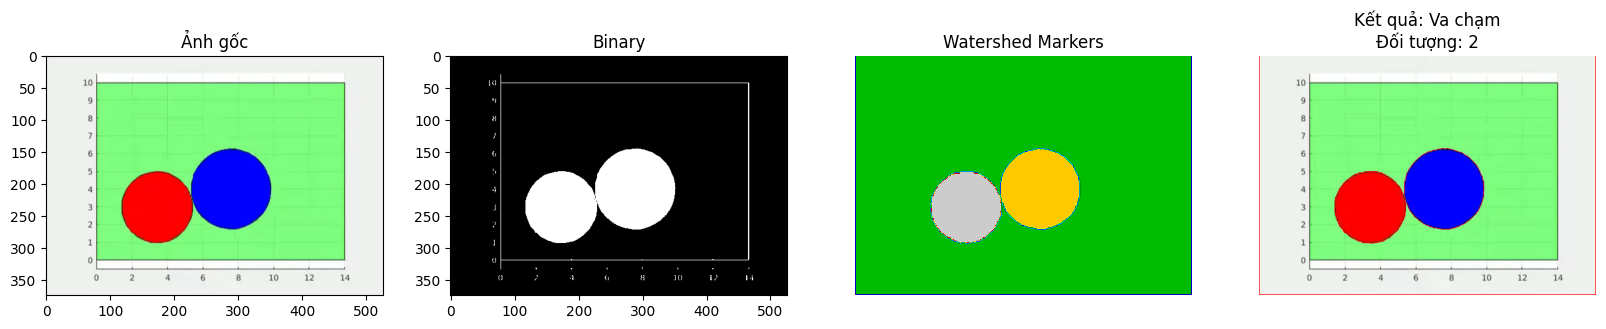

Số đối tượng phát hiện được từ watershed: 2
Kết quả: Va chạm
Khoảng cách nhỏ nhất: 1.41
Elapsed time is 0.525574 seconds.


In [3]:
def check_collision_watershed(image_path):
    # Đọc ảnh đầu vào
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Ngưỡng để phân tách đối tượng
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    
    # Áp dụng morphology để tách các đối tượng chạm nhau
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Background rõ ràng
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Foreground rõ ràng
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.4*dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    
    # Vùng không chắc chắn
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Gán nhãn cho vùng foreground
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0
    
    # Áp dụng watershed
    markers = cv2.watershed(image, markers)
    
    # Đếm số đối tượng từ markers (bỏ qua background (-1) và unknown (0))
    unique_markers = np.unique(markers)[2:]
    num_objects = len(unique_markers)
    
    # Tạo mask cho từng đối tượng
    masks = []
    for marker in unique_markers:
        mask = np.uint8(markers == marker)
        masks.append(mask)
    
    # Kiểm tra va chạm bằng cách tìm khoảng cách giữa các đối tượng
    collision_detected = False
    if len(masks) == 2:
        # Tìm contour cho mỗi mask
        contours1, _ = cv2.findContours(masks[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(masks[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Tìm khoảng cách nhỏ nhất giữa các điểm contour
        min_distance = float('inf')
        for pt1 in contours1[0]:
            for pt2 in contours2[0]:
                dist = np.sqrt((pt1[0][0] - pt2[0][0])**2 + (pt1[0][1] - pt2[0][1])**2)
                min_distance = min(min_distance, dist)
        
        # Nếu khoảng cách nhỏ hơn ngưỡng, coi như va chạm
        collision_detected = min_distance < 4  # Ngưỡng khoảng cách để xác định va chạm
    
    result = "Va chạm" if collision_detected else "Không va chạm"
    
    # Hiển thị kết quả
    plt.figure(figsize=(20, 5))
    
    plt.subplot(141)
    plt.title("Ảnh gốc")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    plt.subplot(142)
    plt.title("Binary")
    plt.imshow(binary, cmap='gray')
    
    plt.subplot(143)
    plt.title("Watershed Markers")
    plt.imshow(markers, cmap='nipy_spectral')
    plt.axis('off')
    
    plt.subplot(144)
    plt.title(f"Kết quả: {result}\nĐối tượng: {num_objects}")
    display_img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    display_img[markers == -1] = [255,0,0]
    plt.imshow(display_img)
    plt.axis('off')
    
    plt.show()
    
    print(f"Số đối tượng phát hiện được từ watershed: {num_objects}")
    print(f"Kết quả: {result}")
    print(f"Khoảng cách nhỏ nhất: {min_distance:.2f}")
    
    return result

t = pytictoc.TicToc()
image_path = 'image1.png'

t.tic()
result = check_collision_watershed(image_path)
t.toc()

## Chạy trên video

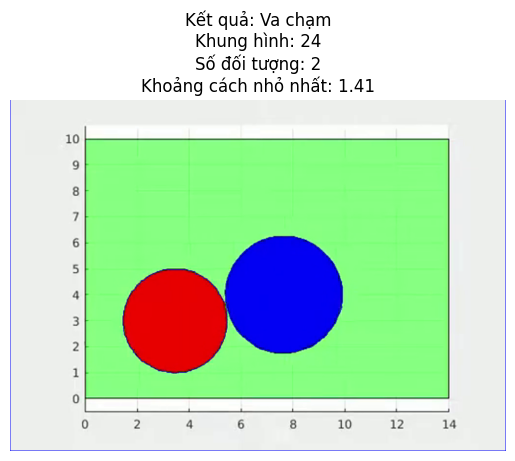

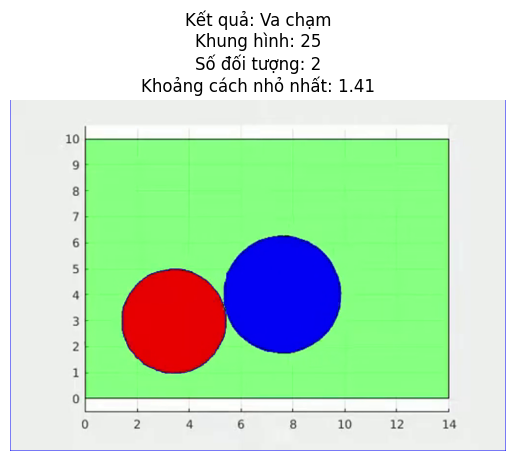

Elapsed time is 6.593829 seconds.


In [4]:
def check_collision_watershed_video(video_path):
    # Đọc video đầu vào
    cap = cv2.VideoCapture(video_path)
    frame_number = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Ngưỡng để phân tách đối tượng
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        
        # Áp dụng morphology để tách các đối tượng chạm nhau
        kernel = np.ones((3,3), np.uint8)
        opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
        
        # Background rõ ràng
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        
        # Foreground rõ ràng
        dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
        sure_fg = np.uint8(sure_fg)
        
        # Vùng không chắc chắn
        unknown = cv2.subtract(sure_bg, sure_fg)
        
        # Gán nhãn cho vùng foreground
        _, markers = cv2.connectedComponents(sure_fg)
        markers = markers + 1
        markers[unknown == 255] = 0
        
        # Áp dụng watershed
        markers = cv2.watershed(frame, markers)
        
        # Đếm số đối tượng từ markers (bỏ qua background (-1) và unknown (0))
        unique_markers = np.unique(markers)[2:]
        num_objects = len(unique_markers)
        
        # Tạo mask cho từng đối tượng
        masks = []
        for marker in unique_markers:
            mask = np.uint8(markers == marker)
            masks.append(mask)
        
        # Kiểm tra va chạm nếu có đủ 2 đối tượng
        collision_detected = False
        min_distance = float('inf')
        if len(masks) == 2:
            # Tìm contour cho mỗi mask
            contours1, _ = cv2.findContours(masks[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            contours2, _ = cv2.findContours(masks[1], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Tìm khoảng cách nhỏ nhất giữa các điểm contour
            for pt1 in contours1[0]:
                for pt2 in contours2[0]:
                    dist = np.sqrt((pt1[0][0] - pt2[0][0])**2 + (pt1[0][1] - pt2[0][1])**2)
                    min_distance = min(min_distance, dist)

            # Nếu khoảng cách nhỏ hơn ngưỡng, coi như va chạm
            collision_detected = min_distance < 4
            
        if collision_detected:
            result_image = frame.copy()
            result_image[markers == -1] = [255, 0, 0]  # Đánh dấu va chạm
            
            # Hiển thị kết quả
            plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
            plt.title(f"Kết quả: Va chạm\nKhung hình: {frame_number}\nSố đối tượng: {num_objects}\nKhoảng cách nhỏ nhất: {min_distance:.2f}")
            plt.axis('off')
            plt.show()
        
        frame_number += 1

    cap.release()

video_path = 'video1.mp4'

time = pytictoc.TicToc()
time.tic()
check_collision_watershed_video(video_path)
time.toc()